# HidPy - Stage 2 : Deconvolution into Discrete Subpopulations using a General Mixture Model (GMM)

## About 

This is the second stage of the HidPy workflow. It loads the intermediate results generated from the analysis of the first stage and applies user-defined deconvolution models and plots the analysis results to complete the workflow.

## 2.1 Import the relevant packages

_Note: Please do NOT edit this panel._ 

In [1]:

## Imports and variables
from copyreg import pickle
import glob
import os
import sys 
from tqdm import tqdm
from pathlib import Path
import numpy as np

import warnings
warnings.filterwarnings('ignore') # Ignore all the warnings 

# Path hidpy
sys.path.append('%s/../' % os.getcwd())

from deconvolution import applyGMM_functions
from deconvolution import applyGMMconstrained_fitout_functions
from deconvolution import importDeconvolutionGMM
import core 


## 2.2 Input panel 

The user must update these parameters to match the parameters in Stage 1.2.

In [2]:
BayesMat = {} 
numDist = 3 # Choose maximum number of distributions

# Pickle files directory 

#pickle_files_directory = '%s/../test_conditions/DataSiR_DNA/Pickles_file_16bits/U2OS_SiR_DNA_Serum_crops/' % os.getcwd()
pickle_files_directory = '%s/../test_conditions/DataSiR_DNA/Pickles_file_16bits/U2OS_SiR_DNA_NoSerum_crops/' % os.getcwd()

# Parameters that will be deconvolved 
parameters2decon=['D','A','V']

# Number of bins of the histograms 
nbins=30

tick_count = 3

## 2.3 Deconvolution GMM Multiple

_Note: Please do NOT edit this panel._ 

100%|██████████| 17/17 [01:52<00:00,  6.62s/it]


Selection:
Distribution type: ['lognormal', 'normal', 'lognormal']
Number of populations: [2 2 2]


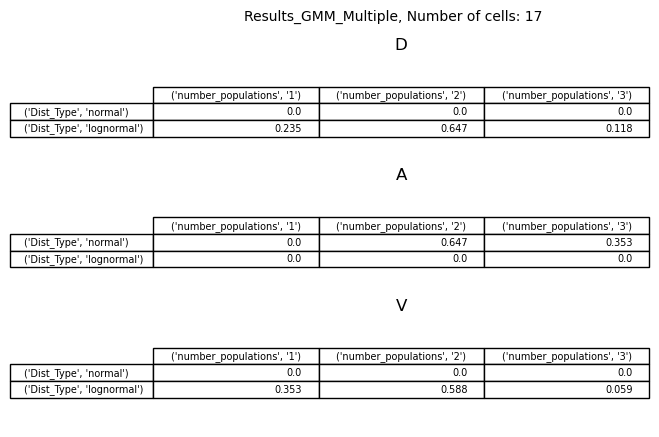

In [3]:
# Read cell pickle files
pickle_files = core.file_utils.list_files_in_directory(directory=pickle_files_directory, extension='.pickle')

# Dictionary with all the Bayes struct per cell
BayesMat=importDeconvolutionGMM.apply_gmm_on_multiple_files(pickle_files, parameters2decon, numDist) # Apply GMM

gmm_multiple_directory = '%s/gmm_multiple/' % pickle_files_directory
core.file_utils.create_directory(gmm_multiple_directory)

Sel_DistributionTypeAuto,Sel_numDistAuto=importDeconvolutionGMM.generatetable_TestGMM(gmm_multiple_directory, BayesMat, parameters2decon) # Make Table

print('Selection:')
print("Distribution type: %s" % Sel_DistributionTypeAuto)
print("Number of populations: %s" % Sel_numDistAuto)

## 2.4 Plotting GMM deconvolution results

_Note: Please do NOT edit this panel._ 

In [4]:
showplots=False

importDeconvolutionGMM.generate_gmm_plots_for_all_parameters(
    output_directory=gmm_multiple_directory, bayes=BayesMat, 
    parameters=parameters2decon, showplots=showplots,number_bins=nbins)


100%|██████████| 17/17 [00:06<00:00,  2.50it/s]


## 2.5 Run GMM based on table and plots for each parameter [D A V]

The user can edit the distribution type and the number of corresponding subpopulations.

In [5]:
# Automatic Selection
Sel_DistributionType=Sel_DistributionTypeAuto
Sel_numDist=Sel_numDistAuto

BayesMatSel=importDeconvolutionGMM.applyGMMconstrained_dir(pickle_files,parameters2decon,Sel_DistributionType,Sel_numDist)

100%|██████████| 17/17 [00:20<00:00,  1.19s/it]


## 2.6 Generate the GMM Constrained Plot

In [6]:
# Generate plots GMM constrained
          
gmm_constrained_directory = '%s/gmm_constrained/' % pickle_files_directory
core.file_utils.create_directory(gmm_constrained_directory)

showplots=False

importDeconvolutionGMM.generateplots_GMMconstrained_fitout(
    gmm_constrained_directory, BayesMatSel, parameters2decon, nbins, Sel_DistributionType, Sel_numDist, showplots)


100%|██████████| 17/17 [00:07<00:00,  2.16it/s]


## 2.7 Deconvolution Statistics: Generate Spatial Mapping of Population Deconvolution

In [7]:
showplots=False

statsMat={}
for i in range(len(BayesMatSel)):
    statsMat[f'File_{i+1}']={}
    for j in range(len(parameters2decon)):
        statsMat[f'File_{i+1}'][parameters2decon[j]]=[]


## Generate plots and statistics
for i in tqdm(range(len(BayesMatSel))):
    for j in range(len(parameters2decon)):
        
        try:
            statsMat[f'File_{i+1}'][parameters2decon[j]]=importDeconvolutionGMM.generate_plots_stats_decon(BayesMatSel[i],parameters2decon[j],gmm_constrained_directory,showplots)
        except:
            filename_without_ext = os.path.splitext(BayesMatSel[i]['filename'])[0]
            print('WARNING: Error generating population label plot: File: '+filename_without_ext+' Parameter: '+parameters2decon[j])


100%|██████████| 17/17 [00:06<00:00,  2.54it/s]


## 2.8 Deconvolution Statistics: Save pickle file per condition

Generate a pickle file with the statistics of the files in the currrent condition. This pickle file will be used in the following notebook to compare conditions.

In [8]:
# Save pickle file per cell
import pickle
from core import file_utils

# Create the pickle directory 
pickle_directory = '%s/pickle' % gmm_constrained_directory
file_utils.create_directory(pickle_directory)

# Save the pickle file 
with open('%s/Statistics.pickle' % (pickle_directory), 'wb') as f:
    pickle.dump(statsMat, f)

# For testing in Matlab to be removed before submission
from scipy.io import savemat
savemat(pickle_directory+"/Statistics.mat",statsMat)

## 2.10 Create the HTML Report 

Generate an HTML report summarizing and tabulating the analysis results of Stage 2.